In [1]:
batch_size = 4000
lr = 0.002
num_epoch = 500
number_of_features = 41
number_of_class_attack_cat = 10
number_of_class_label = 2
hyper_parameter1=128
hyper_parameter2=64
hyper_parameter3=32
hyper_parameter4=16

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from torch.utils.data.dataset import Dataset
from torch.utils.data import random_split, DataLoader
import torch
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as opt

# GPU OR CPU
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("GPU")
else:
    device = torch.device("cpu")
    print("CPU")

GPU


In [4]:
UNSW_NB15 = pd.read_csv("/content/drive/MyDrive/datasets/UNSW-NB15/UNSW_NB15.csv")


indexAge = UNSW_NB15[(UNSW_NB15['attack_cat'] == 'Normal') | (UNSW_NB15['attack_cat'] == 'Generic') | (UNSW_NB15['attack_cat'] == 'Fuzzers') | (UNSW_NB15['attack_cat'] == 'DoS') | (UNSW_NB15['attack_cat'] == 'Analysis') | (UNSW_NB15['attack_cat'] == 'Backdoor')].index
UNSW_NB15.drop(indexAge , inplace=True)

UNSW_NB15_category = UNSW_NB15.copy()
UNSW_NB15_label = UNSW_NB15.copy()

UNSW_NB15

,Unnamed: 0,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
48813,48813,48814,0.000013,udp,-,INT,2,0,240,0,...,1,1,0,0,0,1,1,0,Shellcode,1
48820,48820,48821,0.199274,tcp,-,FIN,10,6,610,268,...,1,1,0,0,0,1,1,0,Shellcode,1
48866,48866,48867,0.179422,tcp,http,FIN,10,6,888,268,...,1,1,0,0,1,1,1,0,Reconnaissance,1
48867,48867,48868,0.000004,udp,-,INT,2,0,168,0,...,1,1,0,0,0,1,2,0,Reconnaissance,1
48869,48869,48870,0.649247,tcp,-,FIN,10,8,564,354,...,1,1,0,0,0,1,1,0,Reconnaissance,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241182,241182,65842,0.205856,tcp,-,FIN,9,8,4764,434,...,1,1,0,0,0,1,1,0,Exploits,1
241183,241183,65843,0.000011,udp,-,INT,2,0,168,0,...,1,1,0,0,0,2,1,0,Reconnaissance,1
241184,241184,65844,0.642848,tcp,-,FIN,10,8,564,354,...,1,1,0,0,0,1,2,0,Reconnaissance,1
241186,241186,65846,0.671189,tcp,-,FIN,10,8,564,354,...,1,1,0,0,0,1,1,0,Reconnaissance,1


In [5]:
class DataSet_UNSWNB15_attack_cat(Dataset):

    def __init__(self,csv_df):
        df = csv_df
        print(df.attack_cat.value_counts().sort_values().plot(kind = "barh"))
        print(df['attack_cat'].value_counts())

        # preprocceing
        df.drop(['id',"Unnamed: 0","service","label"], axis=1, inplace=True)        
        cols = ['attack_cat' ,'proto' ,'state']
        df[cols] = df[cols].apply(LabelEncoder().fit_transform)
        print(df['attack_cat'].value_counts())

        self.data_array = df.values
        self.x = self.data_array[:, :41]
        self.y = self.data_array[:, 41]
      
        # normalaized data
        scaler = preprocessing.StandardScaler().fit(self.x)
        self.x = scaler.transform(self.x)

        self.x = torch.tensor(self.x).float()
        self.y = torch.tensor(self.y).long()

    def __len__(self):
        return len(self.data_array)

    def __getitem__(self, item):
        sample = (self.x[item, :], self.y[item])
        return sample

        
class DataSet_UNSWNB15_label(Dataset):

    def __init__(self, csv_path):
        df = csv_path
        print(df.label.value_counts().sort_values().plot(kind = "pie"))

        # preprocceing
        df.drop(['id',"Unnamed: 0","service","attack_cat"], axis=1, inplace=True)
        cols = ['proto' ,'state']
        df[cols] = df[cols].apply(LabelEncoder().fit_transform)

        self.data_array = df.values
        self.x = self.data_array[:, :41]
        self.y = self.data_array[:, 41]
        
        # normalaized data
        scaler = preprocessing.StandardScaler().fit(self.x)
        self.x = scaler.transform(self.x)

        self.x = torch.tensor(self.x).float()
        self.y = torch.tensor(self.y).long()

    def __len__(self):
        return len(self.data_array)

    def __getitem__(self, item):
        sample = (self.x[item, :], self.y[item])
        return sample

Axes(0.125,0.11;0.775x0.77)
Exploits          44525
Reconnaissance    13987
Shellcode          1511
Worms               174
Name: attack_cat, dtype: int64
0    44525
1    13987
2     1511
3      174
Name: attack_cat, dtype: int64


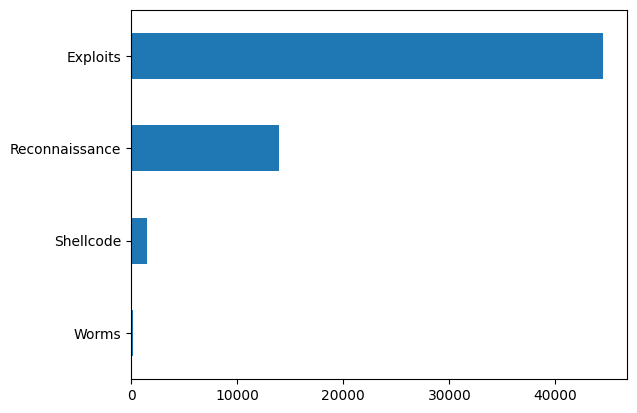

In [6]:
dataset_attack_cat = DataSet_UNSWNB15_attack_cat(UNSW_NB15_category)

number_of_test = int(len(dataset_attack_cat)*0.3)
number_of_train = len(dataset_attack_cat) - int(len(dataset_attack_cat)*0.3)
train_attack_cat ,test_attack_cat = random_split(dataset=dataset_attack_cat, lengths=[number_of_train,number_of_test])

train_attack_cat_dataloader = DataLoader(dataset=train_attack_cat ,batch_size=batch_size ,shuffle=True)
test_attack_cat_dataloader = DataLoader(dataset=test_attack_cat ,batch_size=batch_size ,shuffle=True)

Axes(0.22375,0.11;0.5775x0.77)


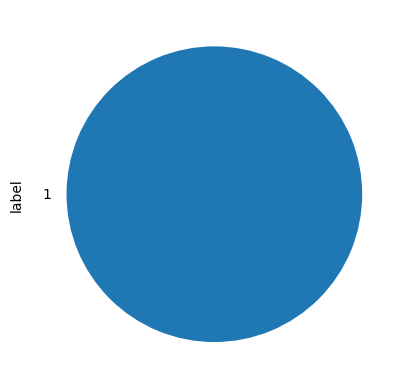

In [7]:
dataset_label = DataSet_UNSWNB15_label(UNSW_NB15_label)
number_of_test = int(len(dataset_label)*0.3)
number_of_train = len(dataset_label) - int(len(dataset_label)*0.3)
train_label ,test_label = random_split(dataset=dataset_label, lengths=[number_of_train,number_of_test])

train_label_dataloader = DataLoader(dataset=train_label ,batch_size=batch_size ,shuffle=True)
test_label_dataloader = DataLoader(dataset=test_label ,batch_size=batch_size ,shuffle=True)

In [8]:
class Model_Attack_Cat(nn.Module):

    def __init__(self):
        super(Model_Attack_Cat, self).__init__()

        self.layers = nn.Sequential(
        nn.Linear(number_of_features, hyper_parameter1),
        nn.Tanh(),
        nn.Linear(hyper_parameter1, hyper_parameter2),
        nn.Tanh(),
        nn.Linear(hyper_parameter2, hyper_parameter3),
        nn.Sigmoid(),
        nn.Linear(hyper_parameter3, hyper_parameter4),
        nn.Sigmoid(),
        nn.Linear(hyper_parameter4,number_of_class_attack_cat)
        )

    def forward(self,x):
        return self.layers(x)

class Model_Label(nn.Module):

    def __init__(self):
        super(Model_Label, self).__init__()

        self.layers = nn.Sequential(
        nn.Linear(number_of_features, hyper_parameter1),
        nn.Tanh(),
        nn.Linear(hyper_parameter1, hyper_parameter2),
        nn.Tanh(),
        nn.Linear(hyper_parameter2, hyper_parameter3),
        nn.Sigmoid(),
        nn.Linear(hyper_parameter3, hyper_parameter4),
        nn.Sigmoid(),
        nn.Linear(hyper_parameter4,number_of_class_label)
        )
      

    def forward(self,x):
         return self.layers(x)

In [9]:
my_model_attack = Model_Attack_Cat().to(device=device)
my_model_attack

Model_Attack_Cat(
  (layers): Sequential(
    (0): Linear(in_features=41, out_features=128, bias=True)
    (1): Tanh()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): Tanh()
    (4): Linear(in_features=64, out_features=32, bias=True)
    (5): Sigmoid()
    (6): Linear(in_features=32, out_features=16, bias=True)
    (7): Sigmoid()
    (8): Linear(in_features=16, out_features=10, bias=True)
  )
)

In [10]:
loss_fn1 = nn.CrossEntropyLoss()
loss_fn2 = nn.CrossEntropyLoss()
optimizer1 = opt.Adam(params=my_model_attack.parameters(),lr=lr)


In [11]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Greens):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


# **train attack cat**

In [12]:
loss_plot = list()

for epoch in range(num_epoch+1):

    for batch_x, batch_y in train_attack_cat_dataloader:

        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        optimizer1.zero_grad()
        loss1 = loss_fn1(my_model_attack(batch_x),batch_y)
        loss1.backward()
        optimizer1.step()

    if epoch % 50 == 0:
        print("loss : %.4f" % (loss1.item()))
        loss_plot.append(loss1.item())



loss : 2.1111
loss : 0.3423
loss : 0.2701
loss : 0.2520
loss : 0.2250
loss : 0.2470
loss : 0.2229
loss : 0.2187
loss : 0.2080
loss : 0.1947
loss : 0.2115


# **test attack cat**

In [13]:
correct = 0
y_test, yhat = list(), list()

for batch_x, labl in test_attack_cat_dataloader:
  
    batch_x = batch_x.to(device)
    labl = labl.to(device)
  
    out = my_model_attack(batch_x)
    _,predicted = torch.max(out,1)
    correct += torch.sum(predicted == labl)
    print(batch_x)
    print(out)
    print(labl)
    print(predicted)
    print("--------------")
    
    for i in labl.cpu().detach().numpy():
        y_test.append(i)
    for i in predicted.cpu().detach().numpy():
        yhat.append(i)


print("acc : %.2f" % (100.*correct / len(test_attack_cat)),end="")
print("%")

tensor([[-0.1494,  0.2759, -0.7429,  ..., -0.4500, -0.5492,  0.0000],
        [ 0.6443,  0.2759, -0.7429,  ..., -0.4500, -0.5492,  0.0000],
        [-0.2664,  0.2312,  1.1333,  ..., -0.2379,  0.9155,  0.0000],
        ...,
        [-0.2310,  0.2759, -0.7429,  ..., -0.4500, -0.5492,  0.0000],
        [-0.1986,  0.2759, -0.7429,  ..., -0.4500, -0.5492,  0.0000],
        [-0.2664, -3.3864,  1.1333,  ...,  0.1864,  0.5493,  0.0000]],
       device='cuda:0')
tensor([[ 6.7861, -0.9978, -4.3376,  ..., -4.7358, -5.5400, -5.3649],
        [ 6.7583, -0.9442, -4.3522,  ..., -4.7407, -5.5401, -5.3748],
        [ 5.3632,  3.2336, -4.7005,  ..., -5.6377, -6.2661, -6.2235],
        ...,
        [ 6.5725, -0.6190, -4.4729,  ..., -4.7537, -5.5197, -5.4188],
        [ 6.7053, -0.8967, -4.3024,  ..., -4.7282, -5.5244, -5.3425],
        [ 5.2628,  3.0537, -3.9692,  ..., -5.6927, -6.2523, -6.2769]],
       device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([0, 0, 0,  ..., 0, 0, 0], device='cuda:0')
tensor([

Confusion matrix, without normalization
[[    0     1     0    56]
 [    0   255    72   108]
 [    0    28  3299   898]
 [    0    77   290 12975]]


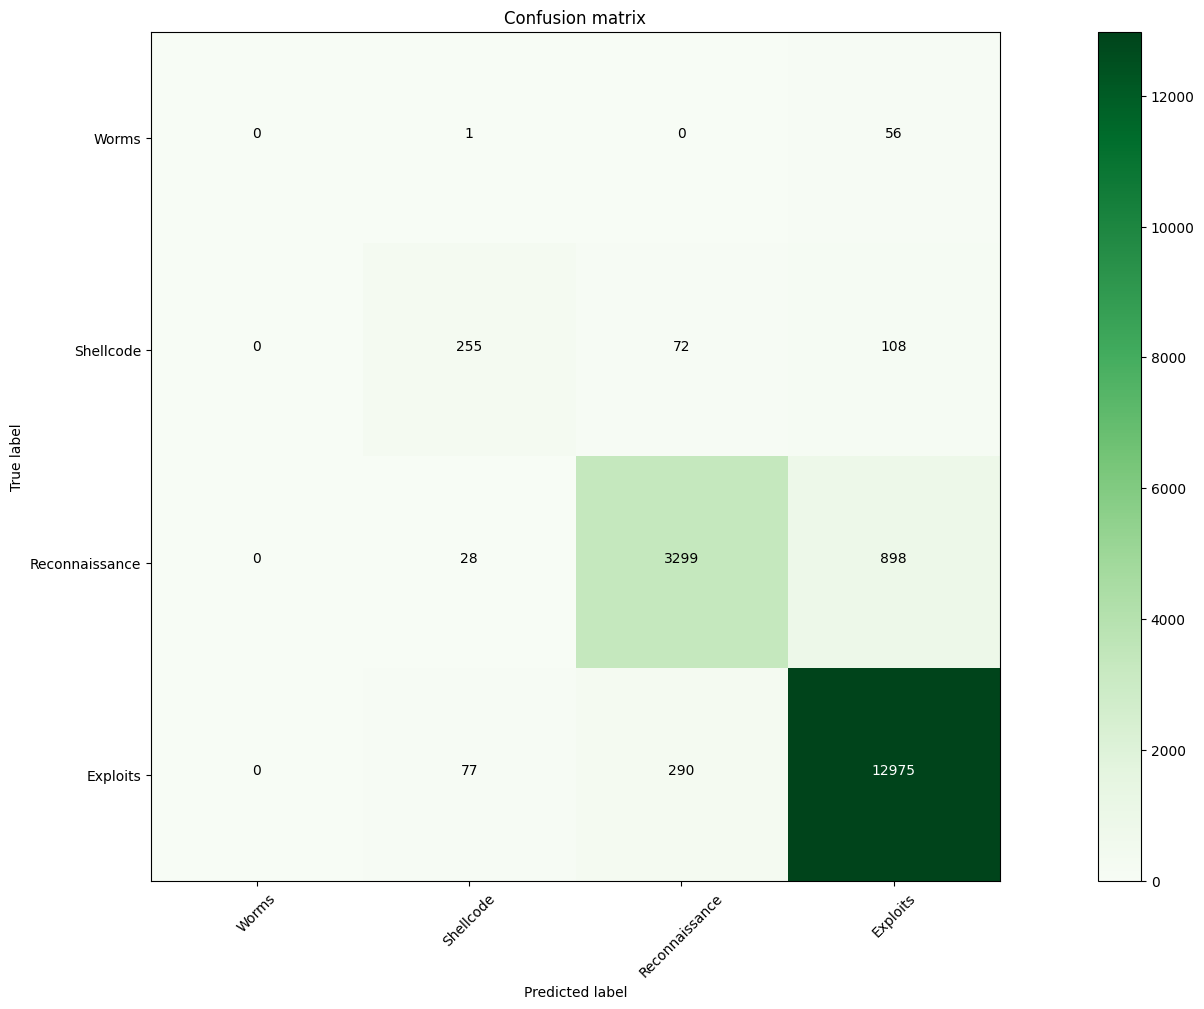

In [16]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat, labels=[3,2,1,0])
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plt.figure(figsize=(20,10))
plot_confusion_matrix(cnf_matrix, classes=['Worms','Shellcode','Reconnaissance','Exploits'],normalize= False,  title='Confusion matrix')

In [17]:
print (classification_report(y_test, yhat))

              precision    recall  f1-score   support

           0       0.92      0.97      0.95     13342
           1       0.90      0.78      0.84      4225
           2       0.71      0.59      0.64       435
           3       0.00      0.00      0.00        57

    accuracy                           0.92     18059
   macro avg       0.63      0.58      0.61     18059
weighted avg       0.91      0.92      0.91     18059



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
